In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (11, 6)

In [26]:
candidates = [
    Path('../../data/robots_missions.csv'),
]

# Sans hyptohèse
robots = pd.read_csv(candidates[0])
robots.head()
robots.info()
robots.columns
robots.dtypes

<class 'pandas.DataFrame'>
RangeIndex: 5409 entries, 0 to 5408
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           5409 non-null   str    
 1   robot_id            5409 non-null   str    
 2   robot_type          5409 non-null   str    
 3   zone                5409 non-null   str    
 4   task_type           5409 non-null   str    
 5   mission_duration_s  5409 non-null   int64  
 6   downtime_s          5409 non-null   int64  
 7   battery_pct         5409 non-null   float64
 8   speed_mps           5409 non-null   float64
 9   temperature_c       5409 non-null   float64
 10  error_code          247 non-null    str    
 11  mission_status      5409 non-null   str    
 12  incident_label      5409 non-null   int64  
dtypes: float64(3), int64(3), str(7)
memory usage: 549.5 KB


timestamp                 str
robot_id                  str
robot_type                str
zone                      str
task_type                 str
mission_duration_s      int64
downtime_s              int64
battery_pct           float64
speed_mps             float64
temperature_c         float64
error_code                str
mission_status            str
incident_label          int64
dtype: object

In [34]:
robots["timestamp"] = pd.to_datetime(robots["timestamp"], errors="coerce")
# errors="coerce" → transforme les erreurs en Nat 

robots["timestamp"].isna().sum() > 0 and "error"

np.False_

In [35]:
# Types numériques attendus
num_cols = ['mission_duration_s', 'downtime_s', 'battery_pct', 'speed_mps', 'temperature_c']
for c in num_cols:
    robots[c] = pd.to_numeric(df[c], errors='coerce')

In [36]:
# Suppression des doublons
robots = robots.drop_duplicates()

# Conserver uniquement les missions dont la durée est strictement positive
robots = robots[robots["mission_duration_s"] > 0]

# Conserver uniquement les pourcentages de batterie valides (entre 0 et 100 inclus)
robots = robots[robots["battery_pct"].between(0, 100)]

In [60]:
robots = robots.rename(columns={
    "timestamp": "event_ts",
    "robot_id" : "id",
    "robot_type": "type",
    "task_type": "task",
    "mission_duration_s": "duration",
    "downtime_s": "downtime",
    "battery_pct": "battery_level",
    "temperature_c": "temperature",
    "mission_status": "status",
    "incident_label": "incident",
    "error_code" : "error"
})

In [61]:
robots.head()

,event_ts,id,type,zone,task,duration,downtime,battery_level,speed_mps,temperature,error,status,incident_type
0,2026-02-02 08:00:00,R01,picker,C1,replenish,174,18,94.46,1.081,25.06,NaN,completed,0
1,2026-02-02 08:00:00,R09,forklift,A1,inventory_scan,179,19,93.04,1.197,22.87,NaN,completed,0
2,2026-02-02 08:10:00,R03,picker,C3,transport,219,13,90.91,1.257,25.00,NaN,completed,0
3,2026-02-02 08:10:00,R01,picker,D1,inventory_scan,242,27,98.40,1.537,25.04,NaN,completed,0
4,2026-02-02 08:20:00,R10,carrier,B2,pick,187,31,98.21,1.082,22.39,NaN,completed,0


In [63]:
robots["error"].notna().mean()

np.float64(0.04550499445061043)

In [65]:
robots["error"].notna().sum()

np.int64(246)

In [66]:
robots["hour"] = robots["event_ts"].dt.hour
robots["day"] = robots["event_ts"].dt.date
robots["is_error"] = np.where(robots["error"].notna(), 1, 0)
# Pour ne pas diviser par zéro
robots = robots[robots["downtime"] > 0]
robots["efficiency"] = robots["duration"] / robots["downtime"]

In [67]:
robots

,event_ts,id,type,zone,task,duration,downtime,battery_level,speed_mps,temperature,error,status,incident_type,hour,day,is_error,efficiency
0,2026-02-02 08:00:00,R01,picker,C1,replenish,174,18,94.46,1.081,25.06,NaN,completed,0,8,2026-02-02,0,9.666667
1,2026-02-02 08:00:00,R09,forklift,A1,inventory_scan,179,19,93.04,1.197,22.87,NaN,completed,0,8,2026-02-02,0,9.421053
2,2026-02-02 08:10:00,R03,picker,C3,transport,219,13,90.91,1.257,25.00,NaN,completed,0,8,2026-02-02,0,16.846154
3,2026-02-02 08:10:00,R01,picker,D1,inventory_scan,242,27,98.40,1.537,25.04,NaN,completed,0,8,2026-02-02,0,8.962963
4,2026-02-02 08:20:00,R10,carrier,B2,pick,187,31,98.21,1.082,22.39,NaN,completed,0,8,2026-02-02,0,6.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5401,2026-02-11 20:00:00,R01,picker,B2,replenish,139,26,21.44,1.614,29.08,NaN,completed,0,20,2026-02-11,0,5.346154
5402,2026-02-11 20:00:00,R11,picker,A1,replenish,227,30,30.01,1.272,29.56,NaN,completed,0,20,2026-02-11,0,7.566667
5403,2026-02-11 20:00:00,R04,carrier,A2,replenish,301,39,32.11,1.146,29.15,NaN,completed,0,20,2026-02-11,0,7.717949
5404,2026-02-11 20:00:00,R05,carrier,A2,inventory_scan,156,27,20.86,0.604,29.64,NaN,completed,0,20,2026-02-11,0,5.777778


In [68]:
robots[["id", "zone", "duration"]]

,id,zone,duration
0,R01,C1,174
1,R09,A1,179
2,R03,C3,219
3,R01,D1,242
4,R10,B2,187
...,...,...,...
5401,R01,B2,139
5402,R11,A1,227
5403,R04,A2,301
5404,R05,A2,156


In [69]:
kpi_hour = robots.groupby("hour", as_index=False).agg(
    missions=("id", "count"),
    error_rate=("is_error", "mean"),
    avg_battery=("battery_level", "mean"),
)

In [70]:
kpi_hour

,hour,missions,error_rate,avg_battery
0,0,194,0.025773,100.000000
1,1,192,0.036458,100.000000
2,2,202,0.034653,99.987574
3,3,188,0.042553,99.932766
4,4,211,0.033175,99.484976
5,5,212,0.018868,98.388632
6,6,194,0.051546,96.915103
7,7,196,0.035714,94.068980
8,8,222,0.022523,90.380811
9,9,201,0.034826,87.113085


In [79]:
robots[["id","hour", "zone", "duration", "task"]].sort_values("hour")

,id,hour,zone,duration,task
2104,R09,0,C1,221,transport
4939,R02,0,C1,213,inventory_scan
4938,R06,0,B2,237,inventory_scan
4937,R01,0,A1,226,pick
4936,R09,0,C3,247,inventory_scan
...,...,...,...,...,...
2090,R12,23,A1,360,charge_transfer
2091,R12,23,C3,195,pick
2092,R01,23,A1,254,inventory_scan
2094,R07,23,C1,283,replenish


In [81]:
df = pd.DataFrame({
    "product": ["A", "A", "B", "B", "B"],
    "quantity": [10, 15, 5, 8, 7]
})

df.groupby("product").agg(
    total =("quantity", "sum")
)

,total
product,
A,25
B,20


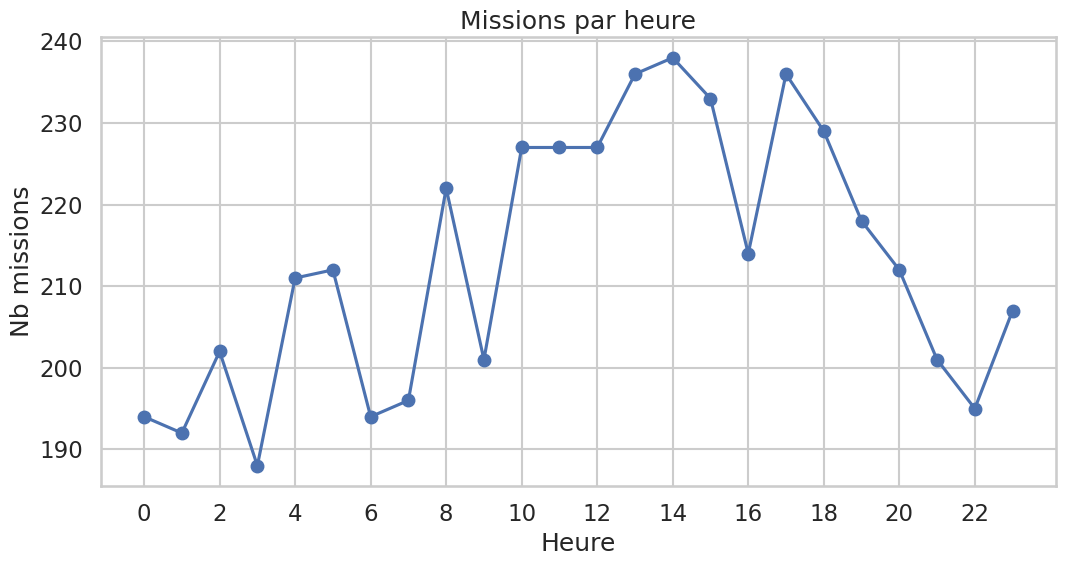

In [82]:
plt.plot(kpi_hour["hour"], kpi_hour["missions"], marker="o")
plt.title("Missions par heure")
plt.xlabel("Heure")
plt.ylabel("Nb missions")
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

In [83]:
(robots["battery_level"] == 100).mean()

np.float64(0.26428012519561817)

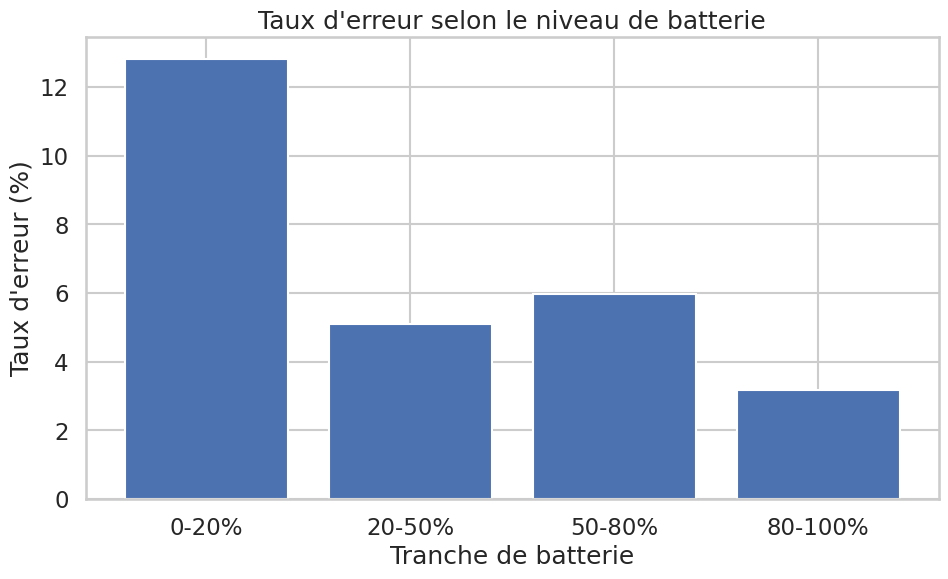

In [85]:
# Calcul du taux d'erreur par tranche
robots["battery_bin"] = pd.cut(
    robots["battery_level"],
    bins=[0, 20, 50, 80, 100],
    labels=["0-20%", "20-50%", "50-80%", "80-100%"]
)


error_by_battery = (
    robots.groupby("battery_bin", as_index=False)["is_error"]
           .mean()
)

# Conversion en pourcentage
error_by_battery["is_error"] *= 100

# Graphique
plt.figure()
plt.bar(
    error_by_battery["battery_bin"].astype(str),
    error_by_battery["is_error"]
)
plt.xlabel("Tranche de batterie")
plt.ylabel("Taux d'erreur (%)")
plt.title("Taux d'erreur selon le niveau de batterie")
plt.show()

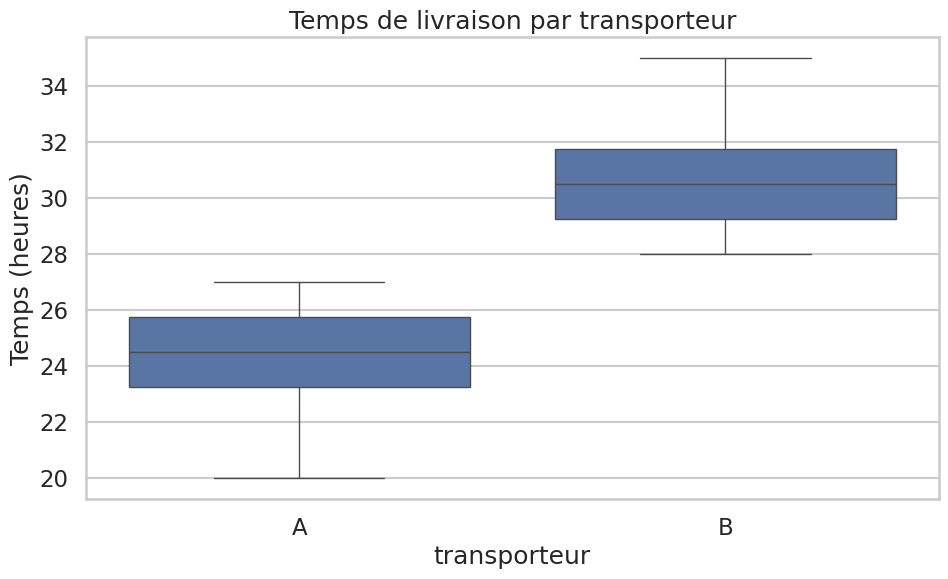

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "transporteur": ["A"]*6 + ["B"]*6,
    "temps_livraison": [24, 26, 25, 23, 27, 20,   # A 
                        30, 32, 31, 29, 28, 35]   # B
})

sns.boxplot(data=df, x="transporteur", y="temps_livraison")
plt.title("Temps de livraison par transporteur")
plt.ylabel("Temps (heures)")
plt.show()

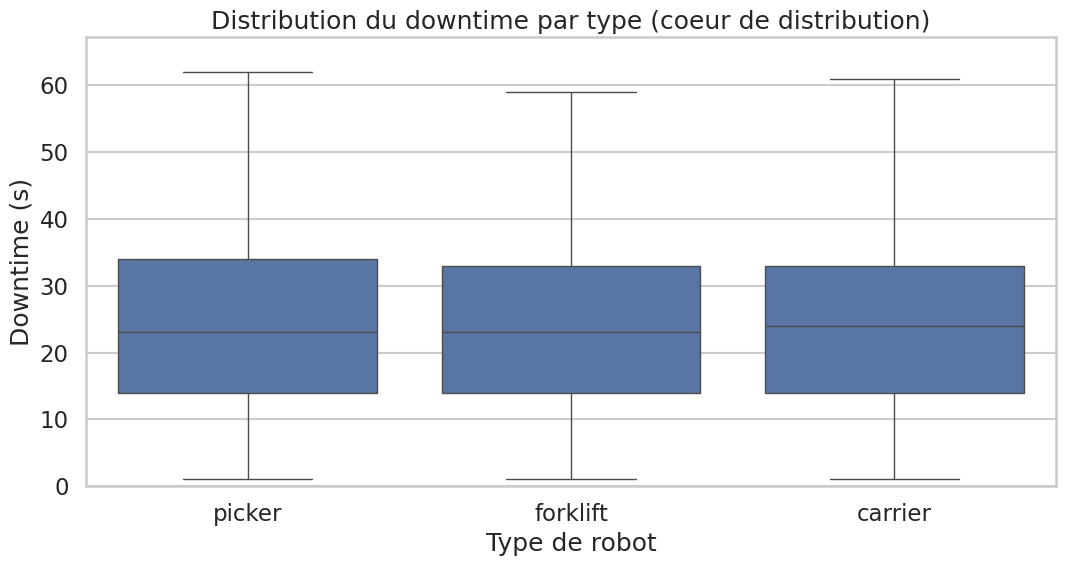

In [93]:
def upper_whisker(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q3 + 1.5 * iqr

upper = robots.groupby("type")["downtime"].apply(upper_whisker).max()
sns.boxplot(data=robots, x="type", y="downtime", showfliers=False)
plt.ylim(0, upper * 1.05)
plt.title("Distribution du downtime par type (coeur de distribution)")
plt.xlabel("Type de robot")
plt.ylabel("Downtime (s)")
plt.tight_layout()
plt.show()

In [94]:
s = pd.Series([10, 12, 13, 15, 18, 19, 20, 100])

def upper_whisker(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q3 + 1.5 * iqr

upper_whisker(s)

29.0